In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

plt.style.use('ggplot')

In [2]:
kq_data = pd.read_csv("sample_data/kenya-airways.csv")
kq_data.reset_index(inplace=True)
kq_data.rename(columns={'index':'id'}, inplace=True)
kq_data.head()

,id,date_published,summary_title,country,trip_verified,review,other_reviews,ratings_10,aircraft,type_of_traveller,cabin_flown,route,recommended,seat_comfort,cabin_staff_service,food_and_beverages,inflight_entertainment,ground_service,value_for_money,wifi_and_connectivity
0,0,2024-06-27,Will fly again,Denmark,Trip Verified,Joburg-Nairobi-Amsterdam 26-27 June 2024 on Bo...,NaN,8.0,Boeing 787-8,Business,Business Class,Johannesburg to Amsterdam via Nairobi,yes,5.0,4.0,4.0,4.0,5.0,4.0,NaN
1,1,2024-06-27,keep on cancelling the flights,Kenya,Not Verified,Horrible airline. They keep on cancelling the ...,NaN,1.0,NaN,Solo Leisure,Economy Class,London Heathrow to Mombasa via Nairobi,no,2.0,3.0,2.0,2.0,2.0,1.0,NaN
2,2,2024-06-27,One of the worst flights,South Africa,Trip Verified,One of the worst flights i have ever experienc...,NaN,3.0,NaN,Family Leisure,Economy Class,Johannesburg to Nairobi,no,1.0,3.0,3.0,2.0,2.0,2.0,1.0
3,3,2024-06-22,Very unprofessional ground staff,India,Not Verified,1. Had paid for seating after which was reques...,NaN,4.0,NaN,Family Leisure,Economy Class,Nairobi to Mumbai,no,2.0,2.0,1.0,NaN,1.0,2.0,NaN
4,4,2024-06-13,refused to compensate me,Canada,Not Verified,I was returning a trip to Kenya. Kenyan Airway...,NaN,1.0,NaN,Family Leisure,Economy Class,Nairobi to Amsterdam,no,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [3]:
# retrieve the review related columns
# columns_to_keep = ["summary_title", "review", "ratings_10"]
# review_data = kq_data[columns_to_keep]
# review_data.head()

In [4]:
# check if there are null values
kq_data[['review', 'ratings_10']].isna().sum()

review        0
ratings_10    7
dtype: int64

In [5]:
# handle null values
kq_data['full_review'] = kq_data['summary_title'] \
  .str.cat(kq_data['review'], sep=' ', na_rep='')

# remove redundant columns
# full_review = review_data.drop(columns=['summary_title', 'review'])
# full_review.head()

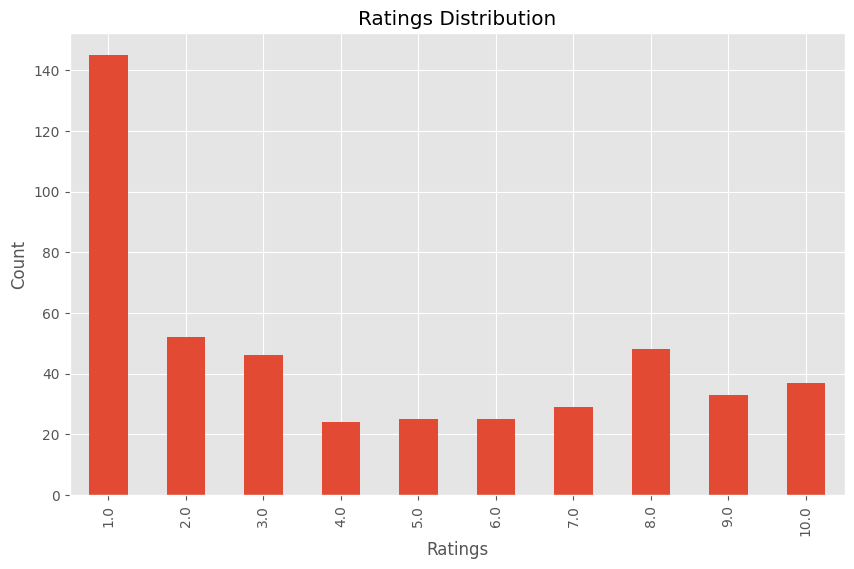

In [6]:
# visualizing the ratings distribution
ax = kq_data['ratings_10'].value_counts().sort_index() \
  .plot(kind='bar', figsize=(10, 6), title="Ratings Distribution")
ax.set_xlabel('Ratings')
ax.set_ylabel('Count')
plt.show()

In [7]:
example_review = kq_data['full_review'][300]
example_review

'Kenya Airways customer review ["DXB to JNB via NBO. Check-in in Dubai took longer than expected, but as most are 3rd party they don\'t care that much to be efficient. Brand new Dreamliner in both legs, good seat arrangement with fair pitch. Onboard entertainment was ok and service above standards (great surprise), good crew. Connection in NBO very smooth. Great value, recommended."]'

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
# run roberta model
encoded_text = tokenizer(example_review, return_tensors='pt')
encoded_text = {key: val.to(device) for key, val in encoded_text.items()}
with torch.no_grad():
  model_output = model(**encoded_text)

scores = model_output.logits[0].cpu().numpy()
scores = softmax(scores)

scores_dict = {
  'roberta_neg' : scores[0],
  'roberta_neu' : scores[1],
  'roberta_pos' : scores[2]
}
print(pd.Series(scores_dict))

roberta_neg    0.015551
roberta_neu    0.119947
roberta_pos    0.864502
dtype: float32


In [10]:
# running on colab's gpu and if no gpu, revert to cpu
def sentiment_polarity_score(example_review):
  # tokenize the review
  encoded_text = tokenizer(example_review, return_tensors='pt',
                           padding='max_length', truncation=True,
                           max_length=512)
  # move the tokenized review to the same device as the model
  encoded_text = {key: val.to(device) for key, val in encoded_text.items()}
  # ensure no gradient computation done
  with torch.no_grad():
    model_output = model(**encoded_text)
  # get the logits and move them to the cpu for further processing
  scores = model_output[0][0].detach().cpu().numpy()
  scores = softmax(scores)
  # scores dictionary
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
  return pd.Series(scores_dict)  #scores_dict

In [11]:
# roberta_columns = ['roberta_neg', 'roberta_neu', 'roberta_pos']
try:
  kq_data[['roberta_neg', 'roberta_neu', 'roberta_pos']] = kq_data['full_review']\
    .apply(lambda x: sentiment_polarity_score(x))
except RuntimeError as e:
  print(e)

In [12]:
# from tqdm.notebook import tqdm
# roberta_results = {}
# for i, row in tqdm(kq_data.iterrows(), total=len(kq_data)):
#   text = row['full_review']
#   myid = row['id']
#   roberta_result = sentiment_polarity_score(text)
#   roberta_results[myid] = roberta_result
# print(roberta_results)

In [13]:
roberta_columns = ['roberta_neg', 'roberta_neu', 'roberta_pos']
kq_data['overall_sentiment'] = kq_data[roberta_columns].max(axis=1)

# Map column names to sentiment labels
sentiment_mapping = {
    'roberta_neg': 'negative',
    'roberta_neu': 'neutral',
    'roberta_pos': 'positive'
}
kq_data['sentiment_label'] = kq_data[roberta_columns].idxmax(axis=1)
kq_data['sentiment_label'] = kq_data['sentiment_label'].map(sentiment_mapping)
# kq_data['sentiment_label']
kq_data.head()

,id,date_published,summary_title,country,trip_verified,review,other_reviews,ratings_10,aircraft,type_of_traveller,...,inflight_entertainment,ground_service,value_for_money,wifi_and_connectivity,full_review,roberta_neg,roberta_neu,roberta_pos,overall_sentiment,sentiment_label
0,0,2024-06-27,Will fly again,Denmark,Trip Verified,Joburg-Nairobi-Amsterdam 26-27 June 2024 on Bo...,NaN,8.0,Boeing 787-8,Business,...,4.0,5.0,4.0,NaN,Will fly again Joburg-Nairobi-Amsterdam 26-27 ...,0.015191,0.178933,0.805876,0.805876,positive
1,1,2024-06-27,keep on cancelling the flights,Kenya,Not Verified,Horrible airline. They keep on cancelling the ...,NaN,1.0,NaN,Solo Leisure,...,2.0,2.0,1.0,NaN,keep on cancelling the flights Horrible airlin...,0.946588,0.048273,0.005139,0.946588,negative
2,2,2024-06-27,One of the worst flights,South Africa,Trip Verified,One of the worst flights i have ever experienc...,NaN,3.0,NaN,Family Leisure,...,2.0,2.0,2.0,1.0,One of the worst flights One of the worst flig...,0.973179,0.023846,0.002976,0.973179,negative
3,3,2024-06-22,Very unprofessional ground staff,India,Not Verified,1. Had paid for seating after which was reques...,NaN,4.0,NaN,Family Leisure,...,NaN,1.0,2.0,NaN,Very unprofessional ground staff 1. Had paid f...,0.877634,0.113443,0.008923,0.877634,negative
4,4,2024-06-13,refused to compensate me,Canada,Not Verified,I was returning a trip to Kenya. Kenyan Airway...,NaN,1.0,NaN,Family Leisure,...,1.0,1.0,1.0,1.0,refused to compensate me I was returning a tri...,0.883592,0.109669,0.006739,0.883592,negative


In [14]:
kq_data.to_csv("review_trained.csv", index=False)